# Title

We will be working with a file of [Major League Baseball](https://en.wikipedia.org/wiki/Major_League_Baseball) games from [Retrosheet](https://www.retrosheet.org/). Retrosheet compiles detailed statistics on baseball games from the 1800s through to today. 

The main file we will be working from `game_log.csv`, has been produced by combining 127 separate CSV files from retrosheet. The game log has hundreds of data points on each game which we will normalize into several separate tables using SQL, providing a robust database of game-level statistics.

In addition to the main file, we have also included three 'helper' files, also sourced from Retrosheet:

- `park_codes.csv`
- `person_codes.csv`
- `team_codes.csv`

These three helper files in some cases contain extra data, but will also make things easier as they will form the basis for three of our normalized tables.

## 1st Subtitle

We will first import all needed packages for this project and then set some options for the Pandas dataframes so they don't get truncated because of the size of the files, and then load all the datasets.

In [1]:
import sqlite3 as sql
import pandas as pd
import csv
from IPython.display import Image

pd.set_option('max_columns', 180)
pd.set_option('max_rows', 200000)
pd.set_option('max_colwidth', 5000)

game = pd.read_csv('game_log.csv',low_memory=False)
park = pd.read_csv('park_codes.csv')
person = pd.read_csv('person_codes.csv')
team = pd.read_csv('team_codes.csv')

Now let's take a look at our datasets to see what we'll be working with.

In [2]:
print(game.shape)
game.head()

(171907, 161)


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional_walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,v_team_earned_runs,v_wild_pitches,v_balks,v_putouts,v_assists,v_errors,v_passed_balls,v_double_plays,v_triple_plays,h_at_bats,h_hits,h_doubles,h_triples,h_homeruns,h_rbi,h_sacrifice_hits,h_sacrifice_flies,h_hit_by_pitch,h_walks,h_intentional_walks,h_strikeouts,h_stolen_bases,h_caught_stealing,h_grounded_into_double,h_first_catcher_interference,h_left_on_base,h_pitchers_used,h_individual_earned_runs,h_team_earned_runs,h_wild_pitches,h_balks,h_putouts,h_assists,h_errors,h_passed_balls,h_double_plays,h_triple_plays,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_1_def_pos,v_player_2_id,v_player_2_name,v_player_2_def_pos,v_player_3_id,v_player_3_name,v_player_3_def_pos,v_player_4_id,v_player_4_name,v_player_4_def_pos,v_player_5_id,v_player_5_name,v_player_5_def_pos,v_player_6_id,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,6.0,1.0,NaN,-1.0,NaN,4.0,1.0,1.0,1.0,0.0,0.0,27.0,9.0,0.0,3.0,0.0,0.0,31.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,-1.0,NaN,3.0,1.0,0.0,0.0,0.0,0.0,27.0,3.0,3.0,1.0,1.0,0.0,boakj901,John Boake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,paboc101,Charlie Pabor,lennb101,Bill Lennon,mathb101,Bobby Mathews,prata101,Al Pratt,NaN,NaN,NaN,NaN,prata101,Al Pratt,mathb101,Bobby Mathews,whitd102,Deacon White,2.0,kimbg101,Gene Kimball,4.0,paboc101,Charlie Pabor,7.0,allia101,Art Allison,8.0,white104,Elmer White,9.0,prata101,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,NaN,1,WS3,NaN,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,NaN,5.0,3.0,NaN,-1.0,NaN,12.0,1.0,6.0,6.0,1.0,0.0,27.0,13.0,10.0,1.0,2.0,0.0,49.0,14.0,2.0,0.0,0.0,11.0,0.0,0.0,0.0,10.0,NaN,2.0,1.0,NaN,-1.0,NaN,14.0,1.0,7.0,7.0,0.0,0.0,27.0,20.0,10.0,2.0,3.0,0.0,dobsh901,Henry Dobson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wrigh101,Harry Wright,younn801,Nick Young,spala101,Al Spalding,braia102,Asa Brainard,NaN,NaN,NaN,NaN,spala101,Al Spalding,braia102,Asa Brainard,wrigg101,George Wright,6.0,barnr102,Ross

It looks like the game log has a record of over 170,000 games, chronologically ordered and occur between 1871 and a few years ago.

For each game we have:

- general information on the game
- team level stats for each team
- a list of players from each team, numbered, with their defensive positions
- the umpires that officiated the game
- some 'awards', like winning and losing pitcher

We have a `game_log_fields.txt` file that tell us that the player number corresponds with the order in which they batted.

In [3]:
print(park.shape)
park.head()

(252, 9)


,park_id,name,aka,city,state,start,end,league,notes
0,ALB01,Riverside Park,NaN,Albany,NY,09/11/1880,05/30/1882,NL,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,NaN,Altoona,PA,04/30/1884,05/31/1884,UA,NaN
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,04/19/1966,NaN,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,04/21/1972,10/03/1993,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,04/11/1994,NaN,AL,NaN


This seems to be a list of all baseball parks. There are IDs which seem to match with the game log, as well as names, nicknames, city and league.

In [4]:
print(person.shape)
person.head()

(20494, 7)


,id,last,first,player_debut,mgr_debut,coach_debut,ump_debut
0,aardd001,Aardsma,David,04/06/2004,NaN,NaN,NaN
1,aaroh101,Aaron,Hank,04/13/1954,NaN,NaN,NaN
2,aarot101,Aaron,Tommie,04/10/1962,NaN,04/06/1979,NaN
3,aased001,Aase,Don,07/26/1977,NaN,NaN,NaN
4,abada001,Abad,Andy,09/10/2001,NaN,NaN,NaN


This seems to be a list of people with IDs. The IDs look like they match up with those used in the game log. There are debut dates, for players, managers, coaches and umpires. We can see that some people might have been one or more of these roles.

It also looks like coaches and managers are two different things in baseball. After some research, managers are what would be called a 'coach' or 'head coach' in other sports, and coaches are more specialized, like base coaches. It also seems like coaches aren't recorded in the game log.

In [5]:
print(team.shape)
team.head()

(150, 8)


,team_id,league,start,end,city,nickname,franch_id,seq
0,ALT,UA,1884,1884,Altoona,Mountain Cities,ALT,1
1,ARI,NL,1998,0,Arizona,Diamondbacks,ARI,1
2,BFN,NL,1879,1885,Buffalo,Bisons,BFN,1
3,BFP,PL,1890,1890,Buffalo,Bisons,BFP,1
4,BL1,NaN,1872,1874,Baltimore,Canaries,BL1,1


This seems to be a list of all teams, with `team_id`'s which seem to match the game log. Interestingly, there is a `franch_id`, let's take a look at this:

In [6]:
team["franch_id"].value_counts().head()

BS1    4
BR3    3
SE1    3
TRN    3
LAA    3
Name: franch_id, dtype: int64

We might have `franch_id` occurring a few times for some teams, let's look at the first one in more detail.

In [7]:
team[team["franch_id"] == 'BS1']

,team_id,league,start,end,city,nickname,franch_id,seq
21,BS1,NaN,1871,1875,Boston,Braves,BS1,1
22,BSN,NL,1876,1952,Boston,Braves,BS1,2
23,MLN,NL,1953,1965,Milwaukee,Braves,BS1,3
24,ATL,NL,1966,0,Atlanta,Braves,BS1,4


It appears that teams move between leagues and cities. The `team_id` changes when this happens, `franch_id` (which is probably 'Franchise') helps us tie all of this together.

__Defensive Positions__

In the game log, each player has a defensive position listed, which seems to be a number between 1-10. Doing some research around this, I found this [article](http://probaseballinsider.com/baseball-instruction/baseball-basics/baseball-basics-positions/) which gives us a list of names for each numbered position:

1. Pitcher
2. Catcher
3. 1st Base
4. 2nd Base
5. 3rd Base
6. Shortstop
7. Left Field
8. Center Field
9. Right Field

The 10th position isn't included, it may be a way of describing a designated hitter that does not field. I can find a retrosheet page that indicates that position 0 is used for this, but we don't have any position 0 in our data. I have chosen to make this an 'Unknown Position' so I'm not including data based on a hunch.

__Leagues__

Wikipedia tells us there are currently two leagues - the American (AL) and National (NL). Let's start by finding out what leagues are listed in the main game log:

In [8]:
game["h_league"].value_counts()

NL    88867
AL    74712
AA     5039
FL     1243
PL      532
UA      428
Name: h_league, dtype: int64

It looks like most of our games fall into the two current leagues, but that there are four other leagues. Let's write a quick function to get some info on the years of these leagues:

In [9]:
def league_info(league):
    league_games = game[game["h_league"] == league]
    earliest = league_games["date"].min()
    latest = league_games["date"].max()
    print("{} went from {} to {}".format(league,earliest,latest))

for league in game["h_league"].unique():
    league_info(league)

nan went from nan to nan
NL went from 18760422 to 20161002
AA went from 18820502 to 18911006
UA went from 18840417 to 18841019
PL went from 18900419 to 18901004
AL went from 19010424 to 20161002
FL went from 19140413 to 19151003


Now we have some years which will help us do some research. After some googling we come up with:

- [National League](https://en.wikipedia.org/wiki/National_League)
- [American League](https://en.wikipedia.org/wiki/American_League)
- [American Association](https://en.wikipedia.org/wiki/American_Association_%2819th_century%29)
- [Federal League](https://en.wikipedia.org/wiki/Federal_League)
- [Players League](https://en.wikipedia.org/wiki/Players%27_League)
- [Union Association](https://en.wikipedia.org/wiki/Union_Association)

It also looks like we have about 1000 games where the home team doesn't have a value for league.

## Importing Data into SQLite

In [10]:
# These helper functions will be useful as we work with the SQLite database from python

DB = "mlb.db"

def run_query(q):
    with sql.connect(DB) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sql.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [11]:
tables = {"game_log": game, "person_codes": person, "team_codes": team, "park_codes": park}

with sql.connect(DB) as conn: 
    for name,df in tables.items():
        conn.execute("DROP TABLE IF EXISTS {};".format(name))
        df.to_sql(name, conn, index=False)

In [12]:
show_tables()

,name,type
0,game_log,table
1,person_codes,table
2,team_codes,table
3,park_codes,table


In [13]:
c1 = '''
ALTER TABLE game_log
ADD COLUMN game_id
'''

# try/except loop since ALTER TABLE
# doesn't support IF NOT EXISTS
try:
    run_command(c1)
except:
    pass

c2 = '''
UPDATE game_log
SET game_id = date || h_name || number_of_game
WHERE game_id IS NULL;
'''

run_command(c2)

q = """
SELECT
    game_id,
    date,
    h_name,
    number_of_game
FROM game_log
LIMIT 5;
"""

run_query(q)

,game_id,date,h_name,number_of_game
0,18710504FW10,18710504,FW1,0
1,18710505WS30,18710505,WS3,0
2,18710506RC10,18710506,RC1,0
3,18710508CH10,18710508,CH1,0
4,18710509TRO0,18710509,TRO,0


## Looking for Normalization Opportunities

The following are opportunities for normalization of our data:

- In `person_codes`, all the debut dates will be able to be reproduced using game log data.
- In `team_codes`, the start, end and sequence columns will be able to be reproduced using game log data.
- In `park_codes`, the start and end years will be able to be reproduced using game log data. While technically the state is an attribute of the city, we might not want to have a an incomplete city/state table so we will leave this in.
- There are lots of places in game log where we have a player ID followed by the players name. We will be able to remove this and use the name data in `person_codes`.
- In `game_log`, all offensive and defensive stats are repeated for the home team and the visiting team. We could break these out and have a table that lists each game twice, one for each team, and cut out this column repetition.
- Similarly, in `game_log`, we have a listing for 9 players on each team with their positions - we can remove these and have one table that tracks player appearances and their positions.
- We can do a similar thing with the umpires from `game_log`, instead of listing all four positions as columns, we can put the umpires either in their own table or make one table for players, umpires and managers.
- We have several awards in `game_log` like winning pitcher and losing pitcher. We can either break these out into their own table, have a table for awards, or combine the awards in with general appearances like the players and umpires.

## Planning a Normalized Schema

The following schema was planned using [DbDesigner.net](https://www.dbdesigner.net/):

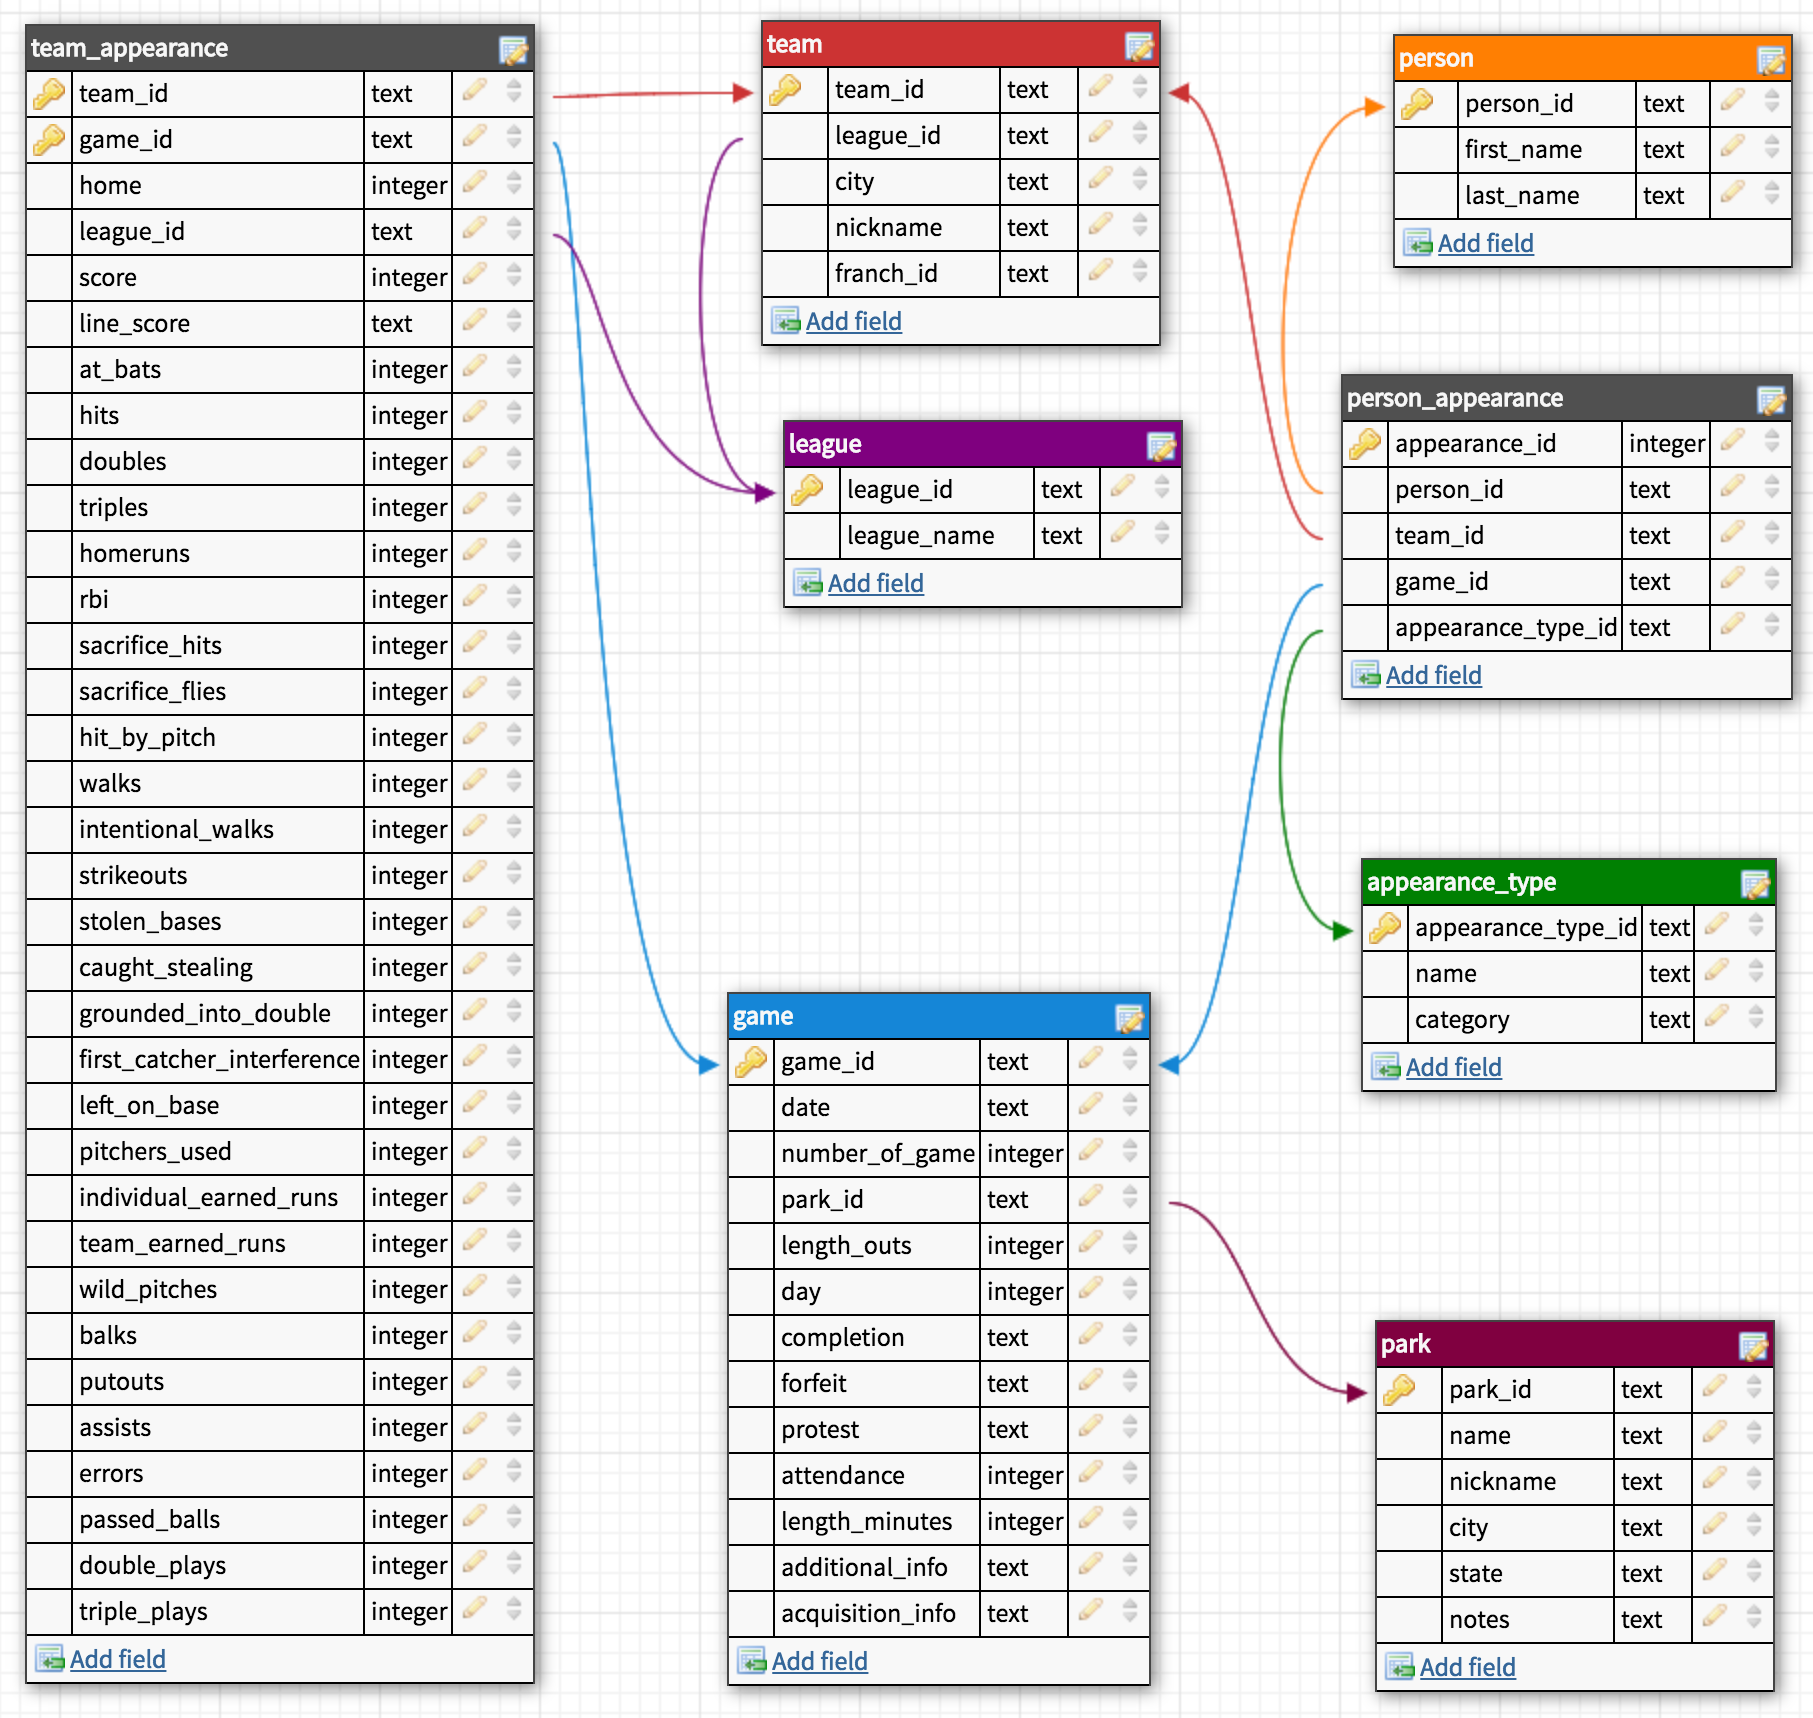

In [14]:
Image("schema.png")

## Creating Tables Without Foreign Keys

In [15]:
c1 = '''
CREATE TABLE IF NOT EXISTS person
(
person_id TEXT PRIMARY KEY,
first_name TEXT,
last_name TEXT
);
'''

c2 = '''
INSERT OR IGNORE INTO person
SELECT
id,
first,
last
FROM person_codes;
'''

q = """
SELECT * FROM person
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,person_id,first_name,last_name
0,aardd001,David,Aardsma
1,aaroh101,Hank,Aaron
2,aarot101,Tommie,Aaron
3,aased001,Don,Aase
4,abada001,Andy,Abad


In [16]:
c1 = '''
CREATE TABLE IF NOT EXISTS park
(
park_id TEXT PRIMARY KEY,
name text,
nickname TEXT,
city TEXT,
state TEXT,
notes TEXT
);
'''

c2 = '''
INSERT OR IGNORE INTO park
SELECT
park_id,
name,
aka,
city,
state,
notes
FROM park_codes;
'''

q = """
SELECT * FROM park
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,park_id,name,nickname,city,state,notes
0,ALB01,Riverside Park,None,Albany,NY,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,None,Altoona,PA,None
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,None
3,ARL01,Arlington Stadium,None,Arlington,TX,None
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,None


In [17]:
c1 = '''
CREATE TABLE IF NOT EXISTS league
(
league_id TEXT PRIMARY KEY,
name TEXT
);
'''

c2 = '''
INSERT OR IGNORE INTO league
VALUES
("NL", "National League"),
("AL", "American League"),
("AA", "American Association"),
("FL", "Federal League"),
("PL", "Players League"),
("UA", "Union Association");
'''

q = """
SELECT * FROM league
"""

run_command(c1)
run_command(c2)
run_query(q)

,league_id,name
0,NL,National League
1,AL,American League
2,AA,American Association
3,FL,Federal League
4,PL,Players League
5,UA,Union Association


In [19]:
c1 = "DROP TABLE IF EXISTS appearance_type;"

run_command(c1)

c2 = """
CREATE TABLE appearance_type
(
appearance_type_id TEXT PRIMARY KEY,
name TEXT,
category TEXT
);
"""
run_command(c2)

appearance_type = pd.read_csv('appearance_type.csv')

with sql.connect('mlb.db') as conn:
    appearance_type.to_sql('appearance_type', conn, index=False, if_exists='append')

q = """
SELECT * FROM appearance_type;
"""

run_query(q)

,appearance_type_id,name,category
0,O1,Batter 1,offense
1,O2,Batter 2,offense
2,O3,Batter 3,offense
3,O4,Batter 4,offense
4,O5,Batter 5,offense
5,O6,Batter 6,offense
6,O7,Batter 7,offense
7,O8,Batter 8,offense
8,O9,Batter 9,offense
9,D1,Pitcher,defense


## Adding the Team and Game tables

In [20]:
c1 = """
CREATE TABLE IF NOT EXISTS team (
    team_id TEXT PRIMARY KEY,
    league_id TEXT,
    city TEXT,
    nickname TEXT,
    franch_id TEXT,
    FOREIGN KEY (league_id) REFERENCES league(league_id)
);
"""

c2 = """
INSERT OR IGNORE INTO team
SELECT
    team_id,
    league,
    city,
    nickname,
    franch_id
FROM team_codes;
"""

q = """
SELECT * FROM team
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,team_id,league_id,city,nickname,franch_id
0,ALT,UA,Altoona,Mountain Cities,ALT
1,ARI,NL,Arizona,Diamondbacks,ARI
2,BFN,NL,Buffalo,Bisons,BFN
3,BFP,PL,Buffalo,Bisons,BFP
4,BL1,None,Baltimore,Canaries,BL1


In [21]:
c1 = """
CREATE TABLE IF NOT EXISTS game (
    game_id TEXT PRIMARY KEY,
    date TEXT,
    number_of_game INTEGER,
    park_id TEXT,
    length_outs INTEGER,
    day BOOLEAN,
    completion TEXT,
    forefeit TEXT,
    protest TEXT,
    attendance INTEGER,
    legnth_minutes INTEGER,
    additional_info TEXT,
    acquisition_info TEXT,
    FOREIGN KEY (park_id) REFERENCES park(park_id)
);
"""

c2 = """
INSERT OR IGNORE INTO game
SELECT
    game_id,
    date,
    number_of_game,
    park_id,
    length_outs,
    CASE
        WHEN day_night = "D" THEN 1
        WHEN day_night = "N" THEN 0
        ELSE NULL
        END
        AS day,
    completion,
    forefeit,
    protest,
    attendance,
    length_minutes,
    additional_info,
    acquisition_info
FROM game_log;
"""

q = """
SELECT * FROM game
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,game_id,date,number_of_game,park_id,length_outs,day,completion,forefeit,protest,attendance,legnth_minutes,additional_info,acquisition_info
0,18710504FW10,18710504,0,FOR01,54,1,None,None,None,200,120,None,Y
1,18710505WS30,18710505,0,WAS01,54,1,None,None,None,5000,145,HTBF,Y
2,18710506RC10,18710506,0,RCK01,54,1,None,None,None,1000,140,None,Y
3,18710508CH10,18710508,0,CHI01,54,1,None,None,None,5000,150,None,Y
4,18710509TRO0,18710509,0,TRO01,54,1,None,None,None,3250,145,HTBF,Y


## Adding the Team Appearance Table

In [22]:
c1 = """
CREATE TABLE IF NOT EXISTS team_appearance (
    team_id TEXT,
    game_id TEXT,
    home BOOLEAN,
    league_id TEXT,
    score INTEGER,
    line_score TEXT,
    at_bats INTEGER,
    hits INTEGER,
    doubles INTEGER,
    triples INTEGER,
    homeruns INTEGER,
    rbi INTEGER,
    sacrifice_hits INTEGER,
    sacrifice_flies INTEGER,
    hit_by_pitch INTEGER,
    walks INTEGER,
    intentional_walks INTEGER,
    strikeouts INTEGER,
    stolen_bases INTEGER,
    caught_stealing INTEGER,
    grounded_into_double INTEGER,
    first_catcher_interference INTEGER,
    left_on_base INTEGER,
    pitchers_used INTEGER,
    individual_earned_runs INTEGER,
    team_earned_runs INTEGER,
    wild_pitches INTEGER,
    balks INTEGER,
    putouts INTEGER,
    assists INTEGER,
    errors INTEGER,
    passed_balls INTEGER,
    double_plays INTEGER,
    triple_plays INTEGER,
    PRIMARY KEY (team_id, game_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id)
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO team_appearance
    SELECT
        h_name,
        game_id,
        1 AS home,
        h_league,
        h_score,
        h_line_score,
        h_at_bats,
        h_hits,
        h_doubles,
        h_triples,
        h_homeruns,
        h_rbi,
        h_sacrifice_hits,
        h_sacrifice_flies,
        h_hit_by_pitch,
        h_walks,
        h_intentional_walks,
        h_strikeouts,
        h_stolen_bases,
        h_caught_stealing,
        h_grounded_into_double,
        h_first_catcher_interference,
        h_left_on_base,
        h_pitchers_used,
        h_individual_earned_runs,
        h_team_earned_runs,
        h_wild_pitches,
        h_balks,
        h_putouts,
        h_assists,
        h_errors,
        h_passed_balls,
        h_double_plays,
        h_triple_plays
    FROM game_log

UNION

    SELECT    
        v_name,
        game_id,
        0 AS home,
        v_league,
        v_score,
        v_line_score,
        v_at_bats,
        v_hits,
        v_doubles,
        v_triples,
        v_homeruns,
        v_rbi,
        v_sacrifice_hits,
        v_sacrifice_flies,
        v_hit_by_pitch,
        v_walks,
        v_intentional_walks,
        v_strikeouts,
        v_stolen_bases,
        v_caught_stealing,
        v_grounded_into_double,
        v_first_catcher_interference,
        v_left_on_base,
        v_pitchers_used,
        v_individual_earned_runs,
        v_team_earned_runs,
        v_wild_pitches,
        v_balks,
        v_putouts,
        v_assists,
        v_errors,
        v_passed_balls,
        v_double_plays,
        v_triple_plays
    from game_log;
"""

run_command(c2)

q = """
SELECT * FROM team_appearance
WHERE game_id = (SELECT MIN(game_id) from game)
   OR game_id = (SELECT MAX(game_id) from game)
ORDER By game_id, home;
"""

run_query(q)

,team_id,game_id,home,league_id,score,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional_walks,strikeouts,stolen_bases,caught_stealing,grounded_into_double,first_catcher_interference,left_on_base,pitchers_used,individual_earned_runs,team_earned_runs,wild_pitches,balks,putouts,assists,errors,passed_balls,double_plays,triple_plays
0,CL1,18710504FW10,0,None,0,000000000,30,4,1,0,0,0,0,0,0,1,NaN,6,1,NaN,-1,NaN,4,1,1,1,0,0,27,9,0,3,0,0
1,FW1,18710504FW10,1,None,2,010010000,31,4,1,0,0,2,0,0,0,1,NaN,0,0,NaN,-1,NaN,3,1,0,0,0,0,27,3,3,1,1,0
2,MIA,20161002WAS0,0,NL,7,000230020,38,14,1,1,2,7,1,0,0,3,2.0,10,1,1.0,1,0.0,8,7,10,10,1,0,24,11,0,0,1,0
3,WAS,20161002WAS0,1,NL,10,03023002x,30,10,2,0,1,10,1,1,1,8,0.0,3,2,0.0,1,0.0,7,6,7,7,1,0,27,11,0,0,1,0


## Adding the Person Appearance Table

In [23]:
c0 = "DROP TABLE IF EXISTS person_appearance"

run_command(c0)

c1 = """
CREATE TABLE person_appearance (
    appearance_id INTEGER PRIMARY KEY,
    person_id TEXT,
    team_id TEXT,
    game_id TEXT,
    appearance_type_id,
    FOREIGN KEY (person_id) REFERENCES person(person_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (appearance_type_id) REFERENCES appearance_type(appearance_type_id)
);
"""

c2 = """
INSERT OR IGNORE INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        NULL,
        hp_umpire_id,
        "UHP"
    FROM game_log
    WHERE hp_umpire_id IS NOT NULL    

UNION

    SELECT
        game_id,
        NULL,
        [1b_umpire_id],
        "U1B"
    FROM game_log
    WHERE "1b_umpire_id" IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [2b_umpire_id],
        "U2B"
    FROM game_log
    WHERE [2b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [3b_umpire_id],
        "U3B"
    FROM game_log
    WHERE [3b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        lf_umpire_id,
        "ULF"
    FROM game_log
    WHERE lf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        rf_umpire_id,
        "URF"
    FROM game_log
    WHERE rf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_manager_id,
        "MM"
    FROM game_log
    WHERE v_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_manager_id,
        "MM"
    FROM game_log
    WHERE h_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_pitcher_id,
        "AWP"
    FROM game_log
    WHERE winning_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score < v_score THEN h_name
            ELSE v_name
            END,
        losing_pitcher_id,
        "ALP"
    FROM game_log
    WHERE losing_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        saving_pitcher_id,
        "ASP"
    FROM game_log
    WHERE saving_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_rbi_batter_id,
        "AWB"
    FROM game_log
    WHERE winning_rbi_batter_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE v_starting_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE h_starting_pitcher_id IS NOT NULL;
"""

template = """
INSERT INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "O{num}"
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL

UNION

    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "D" || CAST({hv}_player_{num}_def_pos AS INT)
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL;
"""

run_command(c1)
run_command(c2)

for hv in ["h","v"]:
    for num in range(1,10):
        query_vars = {
            "hv": hv,
            "num": num
        }
        run_command(template.format(**query_vars))

In [24]:
print(run_query("SELECT COUNT(DISTINCT game_id) games_game FROM game"))
print(run_query("SELECT COUNT(DISTINCT game_id) games_person_appearance FROM person_appearance"))

q = """
SELECT
    pa.*,
    at.name,
    at.category
FROM person_appearance pa
INNER JOIN appearance_type at on at.appearance_type_id = pa.appearance_type_id
WHERE PA.game_id = (
                   SELECT max(game_id)
                    FROM person_appearance
                   )
ORDER BY team_id, appearance_type_id
"""

run_query(q)

   games_game
0      171907
   games_person_appearance
0                   171907


,appearance_id,person_id,team_id,game_id,appearance_type_id,name,category
0,1646109,porta901,None,20161002WAS0,U1B,First Base,umpire
1,1646108,onorb901,None,20161002WAS0,U2B,Second Base,umpire
2,1646107,kellj901,None,20161002WAS0,U3B,Third Base,umpire
3,1646110,tumpj901,None,20161002WAS0,UHP,Home Plate,umpire
4,1646111,brica001,MIA,20161002WAS0,ALP,Losing Pitcher,award
5,6716279,koeht001,MIA,20161002WAS0,D1,Pitcher,defense
6,4744553,telit001,MIA,20161002WAS0,D2,Catcher,defense
7,5589581,bourj002,MIA,20161002WAS0,D3,1st Base,defense
8,4462877,gordd002,MIA,20161002WAS0,D4,2nd Base,defense
9,5026229,pradm001,MIA,20161002WAS0,D5,3rd Base,defense


## Removing the Original Tables

In [25]:
show_tables()

,name,type
0,game_log,table
1,person_codes,table
2,team_codes,table
3,park_codes,table
4,person,table
5,park,table
6,league,table
7,appearance_type,table
8,team,table
9,game,table


In [26]:
tables = [
    "game_log",
    "park_codes",
    "team_codes",
    "person_codes"
]

for t in tables:
    c = '''
    DROP TABLE {}
    '''.format(t)
    
    run_command(c)

show_tables()

,name,type
0,person,table
1,park,table
2,league,table
3,appearance_type,table
4,team,table
5,game,table
6,team_appearance,table
7,person_appearance,table
